In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.9 MB/s eta 0:00:00


In [ ]:
!pip install torch

In [ ]:
!pip install sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install nltk


## Input Original text

In [159]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

def paraphrase_text(input_text):
    # Load the Pegasus model and tokenizer
    model_name = "tuner007/pegasus_paraphrase"
    tokenizer = PegasusTokenizer.from_pretrained(model_name)
    model = PegasusForConditionalGeneration.from_pretrained(model_name)

    # Tokenize and encode the input text
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)

    # Generate paraphrased output
    with torch.no_grad():
        outputs = model.generate(**inputs)
        paraphrased_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return paraphrased_text

# Test the paraphrase function
input_text = input("Enter Text: ")
paraphrased_text = paraphrase_text(input_text)
print("Original Text:", input_text)
print("Paraphrased Text:", paraphrased_text)


Enter Text: Structured Query Language (SQL) is particularly useful in handling structured data.


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original Text: Structured Query Language (SQL) is particularly useful in handling structured data.
Paraphrased Text: Structured data can be handled with the help of Structured Query Language.


##  Create MCQ options

In [ ]:
import random
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from transformers import pipeline

# Download the necessary resources for NLTK (only needed once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Load the paraphrasing model
paraphraser = pipeline("text2text-generation", model="tuner007/pegasus_paraphrase")

# Function to identify keywords (answers) from the paraphrased text
def identify_keywords(paraphrased_text):
    words = nltk.word_tokenize(paraphrased_text)
    stop_words = set(stopwords.words('english'))
    keywords = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    return keywords

# Function to generate MCQs
def generate_mcqs(paraphrased_text, num_options=4):
    # Step 1: Identify keywords (answers) from the paraphrased text
    keywords = identify_keywords(paraphrased_text)
    if not keywords:
        return None

    # Step 2: Substitute the answer with a blank in the sentence
    question_template = paraphrased_text.replace(keywords[0], "______")

    # Step 3: Transform the sentence to look more like a question
    question_template = question_template.strip()
    if not question_template.endswith('?'):
        question_template += "?"

    # Step 4: Generate incorrect answers (distractors)
    # In this example, we just shuffle the keywords as distractors
    distractors = random.sample(keywords, min(num_options-1, len(keywords)-1))

    # Step 5: Create MCQ options (combine correct answer and distractors)
    mcq_options = [keywords[0]] + distractors
    random.shuffle(mcq_options)

    return question_template, mcq_options

# Example usage
input_text = input("Input text: ")
paraphrased_text = paraphraser(input_text, max_length=100, do_sample=True)[0]['generated_text']
mcq_question, mcq_options = generate_mcqs(paraphrased_text)

if mcq_question and mcq_options:
    print("MCQ Question:", mcq_question)
    print("MCQ Options:", mcq_options)
else:
    print("Unable to generate MCQs.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Input text: Structured Query Language (SQL) is particularly useful in handling structured data.
MCQ Question: Structured data can be handled with the help of Structured Query Language.?
MCQ Options: ['language', 'query', 'structured', 'structured']


### Model training

In [ ]:
import nltk
import random
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Download the necessary resources for NLTK (only needed once)
nltk.download('punkt')
nltk.download('stopwords')

# Function to extract features from words
def extract_features(word):
    # Convert word to lowercase
    word = word.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word = " ".join([w for w in word.split() if w not in stop_words])

    # You can explore more feature engineering here

    return word

# Function to prepare the dataset for training
def prepare_dataset(labeled_data):
    features = []
    labels = []
    for word, label in labeled_data:
        features.append(extract_features(word))
        labels.append(label)
    return features, labels

# Function to get user input for labeled data
def get_user_labeled_data():
    labeled_data = []
    while True:
        word = input("Enter a word (type 'exit' to finish): ")
        if word.lower() == 'exit':
            break
        label = input("Is it an answer or non-answer? ")
        labeled_data.append((word, label))
    return labeled_data

# Get user input for labeled data
print("Enter labeled words and their corresponding labels (answer or non-answer).")
print("Type 'exit' when you're done.")
user_labeled_data = get_user_labeled_data()

# Prepare the dataset
features, labels = prepare_dataset(user_labeled_data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Vectorize the features
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train the Gaussian Naive Bayes model
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_vectorized.toarray(), y_train)

# Make predictions on the test set
y_pred = naive_bayes_model.predict(X_test_vectorized.toarray())

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)


## Creating question


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string

def identify_keywords(paragraph, num_keywords=4):
    sentences = sent_tokenize(paragraph)
    word_freq = {}
    for sentence in sentences:
        words = word_tokenize(sentence.lower())
        words = [word for word in words if word not in stopwords.words('english') and word not in string.punctuation]
        for word in words:
            word_freq[word] = word_freq.get(word, 0) + 1

    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    keywords = [word for word, _ in sorted_words[:num_keywords]]
    return keywords

# Example usage:
paragraph = "Albert Einstein was a German-born theoretical physicist who developed the theory of relativity, \
            one of the two pillars of modern physics. His work is also known for its influence on the philosophy of science."
keywords = identify_keywords(paragraph)
print(keywords)  # Output: ['physics', 'einstein', 'theory', 'relativity']


['albert', 'einstein', 'german-born', 'theoretical']


In [ ]:
def substitute_with_blank(sentence, keyword):
    return sentence.replace(keyword, "_____")

# Example usage:
sentence = "Albert Einstein developed the theory of relativity."
keyword = "relativity"
question_stem = substitute_with_blank(sentence, keyword)
print(question_stem)  # Output: "Albert Einstein developed the theory of _____."


Albert Einstein developed the theory of _____.


In [ ]:
def make_question_like(sentence):
    if sentence.startswith(("What", "When", "Where", "Which", "Who", "Whose", "Why", "How")):
        return sentence + "?"
    else:
        return "What " + sentence + "?"

# Example usage:
sentence = "Albert Einstein developed the theory of relativity."
question_like = make_question_like(sentence)
print(question_like)  # Output: "What Albert Einstein developed the theory of relativity."


What Albert Einstein developed the theory of relativity.?


In [ ]:
from nltk.corpus import wordnet

def generate_distractors(keyword, num_distractors=3):
    distractors = set()
    synonyms = wordnet.synsets(keyword)
    for syn in synonyms:
        for lemma in syn.lemmas():
            distractors.add(lemma.name().replace("_", " "))
    distractors.discard(keyword)
    distractors = list(distractors)[:num_distractors]
    return distractors

# Example usage:
keyword = "relativity"
distractors = generate_distractors(keyword)
print(distractors)  # Output: ['relativistic mechanics', 'relativism', 'relativistic theory']


["Einstein's theory of relativity", 'relativity theory', 'theory of relativity']


In [ ]:
!pip install Pillow


In [ ]:
!pip install opencv-python
!pip install matplotlib


In [ ]:
!pip install opencv-python
!pip install numpy


## Grading the OMR sheet


In [ ]:
import sys
sys.argv = ["bubble_sheet_scanner.py", "-i", "/content/Capture3.PNG"]


In [ ]:
!pip install --upgrade imutils

In [ ]:
from google.colab.patches import cv2_imshow

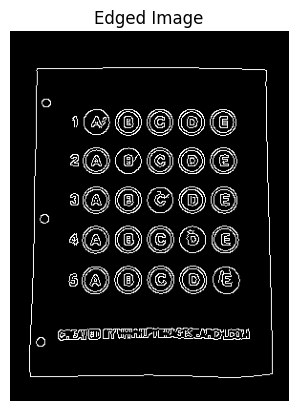

In [ ]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="/content/Capture3.PNG")
args = vars(ap.parse_args())

# define the answer key which maps the question number
# to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

# Set the title for the image
title = "Edged Image"
plt.figure()
plt.imshow(edged, cmap='gray')
plt.title(title)
plt.axis('off')  # Turn off axis labels
plt.show()



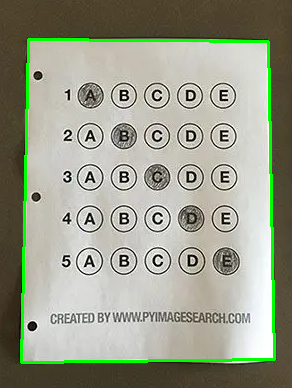

In [ ]:
# Find contours in the edge map, then initialize the contour that corresponds to the document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

# Ensure that at least one contour was found
if len(cnts) > 0:
    # Sort the contours according to their size in descending order
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    # Loop over the sorted contours
    for c in cnts:
        # Approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # If our approximated contour has four points,
        # then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break

# Draw the contour on the original image
if docCnt is not None:
    cv2.drawContours(image, [docCnt], -1, (0, 255, 0), 2)
# Show the output image with the detected document contour using cv2_imshow
from google.colab.patches import cv2_imshow
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [ ]:
# apply a four point perspective transform to both the original image and grayscale image to obtain a top-down birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

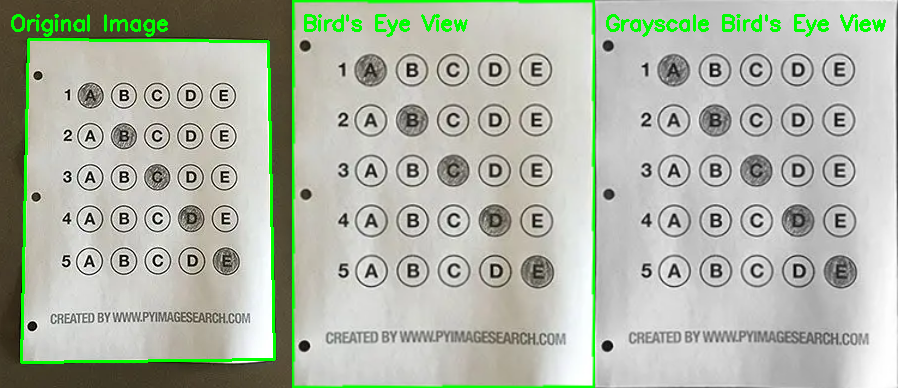

In [ ]:
# Apply a four point perspective transform to both the original image and grayscale image
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

# Resize the images to have the same height
height = max(image.shape[0], paper.shape[0], warped.shape[0])
image_resized = cv2.resize(image, (int(image.shape[1] * height / image.shape[0]), height))
paper_resized = cv2.resize(paper, (int(paper.shape[1] * height / paper.shape[0]), height))
warped_resized = cv2.resize(warped, (int(warped.shape[1] * height / warped.shape[0]), height))

# Concatenate the images horizontally with titles
result_image = np.hstack((cv2.putText(image_resized.copy(), "Original Image", (10, 30),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2),
                          cv2.putText(paper_resized.copy(), "Bird's Eye View", (10, 30),
                                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2),
                          cv2.putText(cv2.cvtColor(warped_resized.copy(), cv2.COLOR_GRAY2BGR), "Grayscale Bird's Eye View", (10, 30),
                                      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)))

# Show the output image horizontally using cv2_imshow for Google Colab
from google.colab.patches import cv2_imshow
cv2_imshow(result_image)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
# Apply Otsu's thresholding method to binarize the warped piece of paper
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# Find contours in the thresholded image, then initialize the list of contours that correspond to questions
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
questionCnts = []

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # in order to label the contour as a question, region should be sufficiently wide, sufficiently tall,
    # and have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)

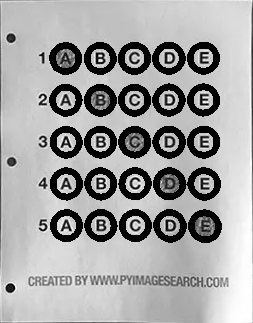

In [ ]:
# Draw the contours representing the bubbles on the original image
output_image = warped.copy()

cv2.drawContours(output_image, questionCnts, -1, (0, 0, 255), 5)

# Show the output image with the identified bubbles
from google.colab.patches import cv2_imshow
cv2_imshow(output_image)

cv2.waitKey(0)
cv2.destroyAllWindows()


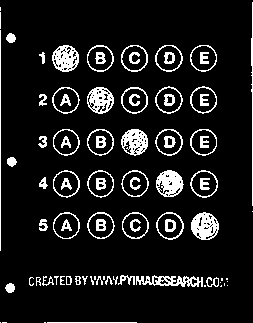

In [ ]:
# Apply Otsu's thresholding method to binarize the warped piece of paper
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

from google.colab.patches import cv2_imshow
cv2_imshow(thresh)

cv2.waitKey(0)
cv2.destroyAllWindows()

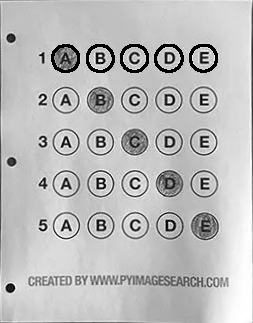

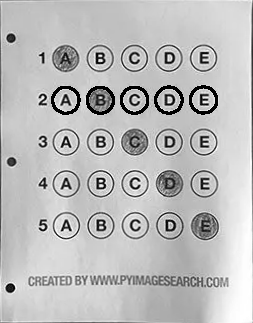

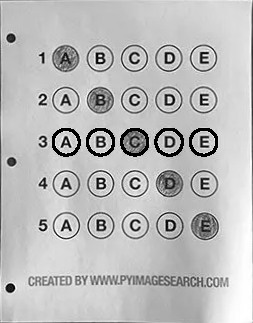

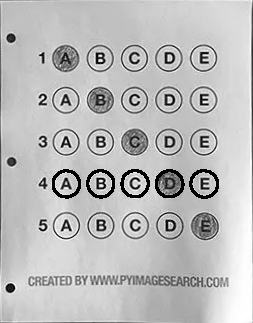

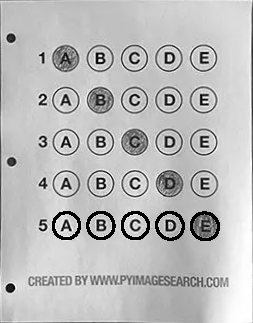

In [ ]:
# Sort the question contours top-to-bottom
questionCnts = contours.sort_contours(questionCnts, method="top-to-bottom")[0]

# Initialize the total number of correct answers
correct = 0

# Loop over the question contours in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # Sort the contours for the current question from left to right
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None
    # Draw the contours representing the bubbles on the original image
    output_image = warped.copy()
    cv2.drawContours(output_image, cnts, -1, (0, 0, 255), 2)

    # Show the output image with the identified bubbles
    from google.colab.patches import cv2_imshow
    cv2_imshow(output_image)

cv2.waitKey(0)
cv2.destroyAllWindows()


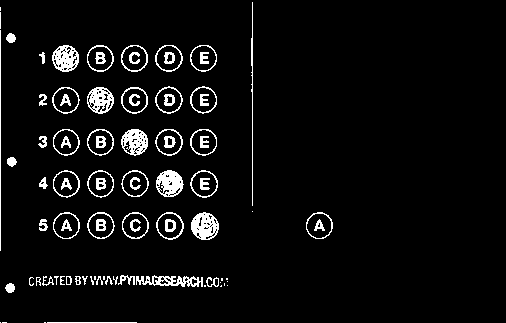

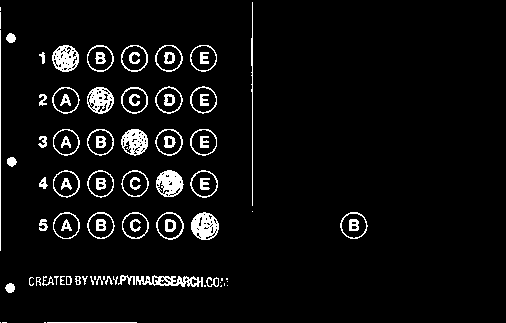

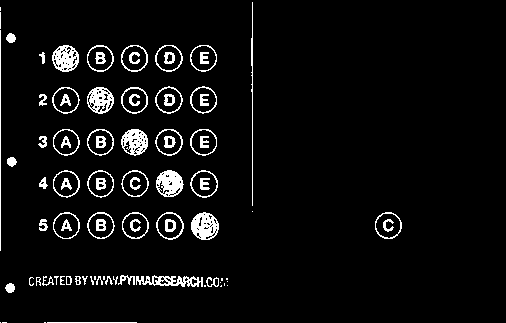

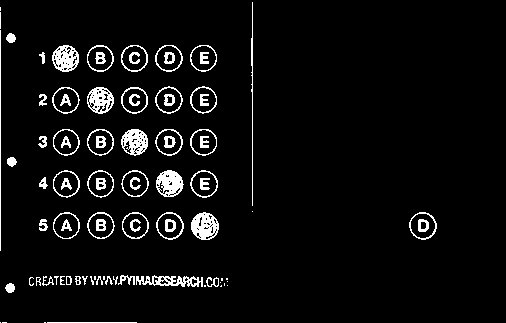

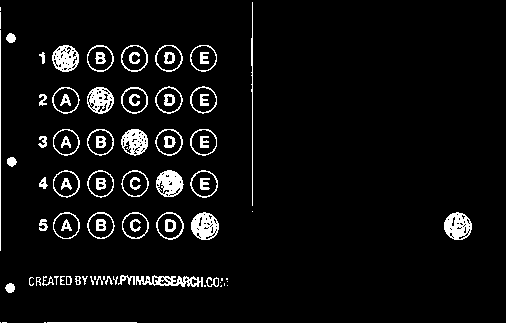

In [ ]:
# Loop over the sorted contours
for (j, c) in enumerate(cnts):
    # Construct a mask that reveals only the current "bubble" for the question
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)

    # Apply the mask to the thresholded image
    masked_image = cv2.bitwise_and(thresh, thresh, mask=mask)

    # Count the number of non-zero pixels in the bubble area
    total = cv2.countNonZero(masked_image)

    # Display the thresholded image and the mask for the current bubble
    output_image = np.hstack((thresh, masked_image))
    from google.colab.patches import cv2_imshow
    cv2_imshow(output_image)
    cv2.waitKey(0)

    # If the current total has a larger number of total non-zero pixels,
    # then we are examining the currently bubbled-in answer
    if bubbled is None or total > bubbled[0]:
        bubbled = (total, j)

In [ ]:
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # Sort the contours for the current question from left to right
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None

   # Loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # Construct a mask that reveals only the current "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)

        # Apply the mask to the thresholded image, then count the number of non-zero pixels in the bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)

        # If the current total has a larger number of total non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)

    # Draw the contours representing the bubbles on the original image
    output_image = warped.copy()  # Copy the warped image to draw the contours
    cv2.drawContours(output_image, cnts, -1, (0, 0, 255), 2)

    # If we found the chosen answer (bubbled answer), draw it in green
    if bubbled is not None:
        cv2.drawContours(output_image, [cnts[bubbled[1]]], -1, (0, 255, 0), 2)

    # Initialize the contour color and the index of the *correct* answer
    color = (0, 0, 255)
    k = ANSWER_KEY[q]

    # Check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)
        correct += 1

    # Draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

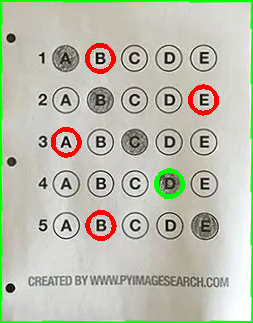

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(paper)

cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
# Calculate the test taker's score
score = (correct / 5.0) * 100

# Set the threshold value for half-circle marked bubbles (adjust as needed)
threshold_value = 100
some_threshold_value = 1000
# Check if the user has marked any bubbles with a half-circle
half_marked = False
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None
    num_marked_bubbles = 0

    # Loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # Construct a mask that reveals only the current "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)

        # Apply the mask to the thresholded image, then count the number of non-zero pixels in the bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)

        # If the current total has a larger number of total non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)

        # Check if a half-circle marked bubble is found
        if total < threshold_value:
            half_marked = True
            break

        # Check if there are multiple marked bubbles
        if total > some_threshold_value:  # Adjust some_threshold_value based on your specific case
            num_marked_bubbles += 1

    if half_marked or num_marked_bubbles > 1:
        break

# Check if the user has not marked any bubbles
if correct == 0:
    print("User has not marked any bubbles.")

# Display the score on the paper image (only if there are no half-circle marked bubbles or multiple marked bubbles)
if not half_marked and num_marked_bubbles <= 1:
    print("[INFO] score: {:.2f}%".format(score))
    cv2.putText(paper, "{:.2f}%".format(score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
else:
    if half_marked:
        print("User has half-circle marked some bubbles. Score not included.")
    else:
        print("User has marked multiple bubbles for a question. Score not included.")



[INFO] score: 20.00%


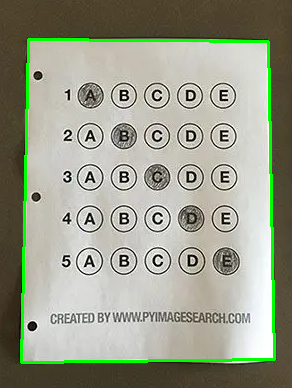

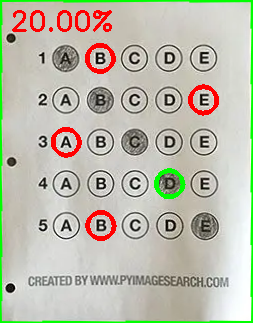

In [ ]:
# Display the score on the paper image
cv2.putText(paper, "{:.2f}%".format(score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

# Show the original and graded exam images using cv2_imshow for Google Colab
from google.colab.patches import cv2_imshow
cv2_imshow(image)
cv2_imshow(paper)


cv2.waitKey(0)
cv2.destroyAllWindows()
